# Fitting linecuts using the lmfit package

## Import functions

In [4]:
from nxs_analysis_tools.datareduction import load_transform, Scissors
from nxs_analysis_tools.fitting import LinecutModel
from nxs_analysis_tools.datasets import cubic

from lmfit.models import GaussianModel, LinearModel
import numpy as np
import matplotlib.pyplot as plt

# Download example data and save cache directory as sample_directory
sample_directory = cubic(temperatures=[15])

## Load data

In [5]:
data = load_transform(f'{sample_directory}/cubic_15.nxs')

data:NXdata
  @axes = ['Qh', 'Qk', 'Ql']
  @signal = 'counts'
  Qh = float64(100)
  Qk = float64(150)
  Ql = float64(200)
  counts = float64(100x150x200)


## Perform linecuts

In [6]:
s = Scissors(data=data)

In [7]:
linecut = s.cut_data(center=(0,0,0), window=(0.1,0.5,0.1))

## The `LinecutModel` class

The workhorse of the fitting algorithm here is the `LinecutModel` class which wraps both the `Model` and `ModelResult` classes of the `lmfit` package, among other information.

In [8]:
lm = LinecutModel(data=linecut)

## Create `lmfit` model

Use the `.set_model_components()` method to set the model to be used for fitting the linecut. The `model_components` parameter must be a `Model`, `CompositeModel`, or `list` of `Model` objects.

In [9]:
# Using a list of Model objects
lm.set_model_components([GaussianModel(prefix='peak'), LinearModel(prefix='background')])

# Using a CompositeModel
lm.set_model_components(GaussianModel(prefix='peak') + LinearModel(prefix='background'))

Upon setting the model, the `.params` attribute is initialized with a `Parameters` object which holds the parameters for all components of the model.

In [10]:
lm.params

name,value,initial value,min,max,vary,expression
peakamplitude,1.00000000,None,-inf,inf,True,
peakcenter,0.00000000,None,-inf,inf,True,
peaksigma,1.00000000,None,0.00000000,inf,True,
backgroundslope,1.00000000,None,-inf,inf,True,
backgroundintercept,0.00000000,None,-inf,inf,True,
peakfwhm,2.35482000,None,-inf,inf,False,2.3548200*peaksigma
peakheight,0.39894230,None,-inf,inf,False,"0.3989423*peakamplitude/max(1e-15, peaksigma)"


## Performing an initial guess

Use the `.guess()` method to perform an initial guess, which will overwrite any changes made to the parameter values and constraints set in the `.params` attribute.

In [11]:
lm.guess()

[Parameters([('peakamplitude', <Parameter 'peakamplitude', value=482528.7250417659, bounds=[-inf:inf]>), ('peakcenter', <Parameter 'peakcenter', value=-7.401486830834377e-17, bounds=[-inf:inf]>), ('peaksigma', <Parameter 'peaksigma', value=0.05033557046979864, bounds=[0.0:inf]>), ('peakfwhm', <Parameter 'peakfwhm', value=0.11853120805369124, bounds=[-inf:inf], expr='2.3548200*peaksigma'>), ('peakheight', <Parameter 'peakheight', value=3824355.5717666983, bounds=[-inf:inf], expr='0.3989423*peakamplitude/max(1e-15, peaksigma)'>)]),
 Parameters([('backgroundslope', <Parameter 'backgroundslope', value=9.271792676819166e-11, bounds=[-inf:inf]>), ('backgroundintercept', <Parameter 'backgroundintercept', value=404986.4717240573, bounds=[-inf:inf]>)])]

To view the guessed initial values, we can inspect the `.params` attribute.

In [12]:
lm.params

name,value,initial value,min,max,vary,expression
peakamplitude,482528.725,482528.7250417659,-inf,inf,True,
peakcenter,-7.4015e-17,-7.401486830834377e-17,-inf,inf,True,
peaksigma,0.05033557,0.05033557046979864,0.00000000,inf,True,
backgroundslope,9.2718e-11,9.271792676819166e-11,-inf,inf,True,
backgroundintercept,404986.472,404986.4717240573,-inf,inf,True,
peakfwhm,0.11853121,None,-inf,inf,False,2.3548200*peaksigma
peakheight,3824355.57,None,-inf,inf,False,"0.3989423*peakamplitude/max(1e-15, peaksigma)"


## Visualize the initial guesses

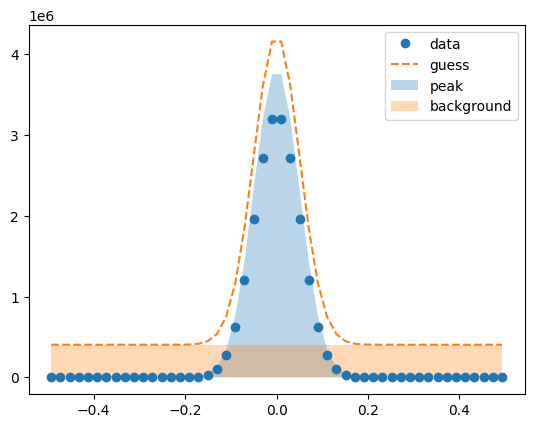

In [13]:
lm.plot_initial_guess()

## Set parameter constraints

All constraints are set by accessing the individiual parameters through the `.params` attribute. See [https://lmfit.github.io/lmfit-py/constraints.html](https://lmfit.github.io/lmfit-py/constraints.html) for more information on mathematical constraints allowed by `lmfit`.

In [14]:
# Constrain the peak amplitude to be positive
lm.params['peakamplitude'].set(min=0)

# Constrain the range of the peak center
lm.params['peakcenter'].set(min=-0.1, max=0.1)

If we inspect the `.params` attribute again, we should see that the constraints are implemented.

In [15]:
lm.params

name,value,initial value,min,max,vary,expression
peakamplitude,482528.725,482528.7250417659,0.00000000,inf,True,
peakcenter,-7.4015e-17,-7.401486830834377e-17,-0.10000000,0.10000000,True,
peaksigma,0.05033557,0.05033557046979864,0.00000000,inf,True,
backgroundslope,9.2718e-11,9.271792676819166e-11,-inf,inf,True,
backgroundintercept,404986.472,404986.4717240573,-inf,inf,True,
peakfwhm,0.11853121,None,-inf,inf,False,2.3548200*peaksigma
peakheight,3824355.57,None,-inf,inf,False,"0.3989423*peakamplitude/max(1e-15, peaksigma)"


## Perform the fit

The `.fit()` method here automatically assumes the parameter values and constraints currently stored in the `.params` attribute and feeds them to the `.fit()` method from `lmfit`. 

In [16]:
lm.fit()

## Visualize the fit

Once the fit is complete, we can visualize the fit and the residuals using the `.plot_fit()` method.

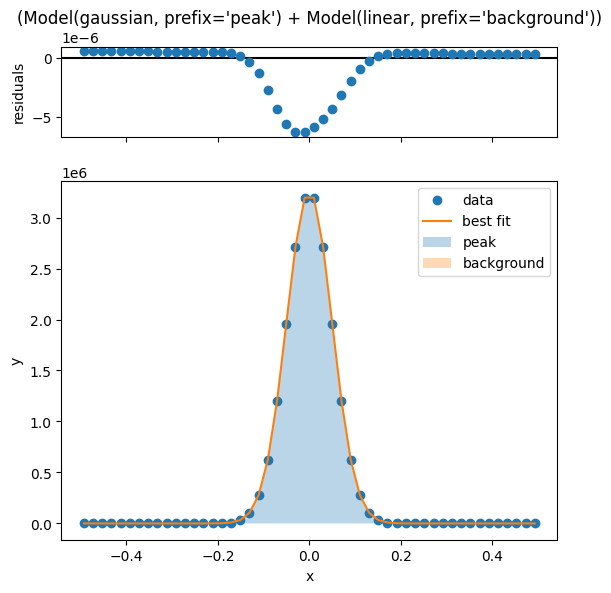

[[Model]]
    (Model(gaussian, prefix='peak') + Model(linear, prefix='background'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 50
    # variables        = 5
    chi-square         = 2.4461e-10
    reduced chi-square = 5.4358e-12
    Akaike info crit   = -1292.16869
    Bayesian info crit = -1282.60857
    R-squared          = 1.00000000
##  Warning: uncertainties could not be estimated:
    peakcenter:           at initial value
[[Variables]]
    peakamplitude:        407704.502 (init = 482528.7)
    peakcenter:          -1.7472e-14 (init = -7.401487e-17)
    peaksigma:            0.04987484 (init = 0.05033557)
    backgroundslope:      2.7009e-07 (init = 9.271793e-11)
    backgroundintercept: -4.9024e-07 (init = 404986.5)
    peakfwhm:             0.11744628 == '2.3548200*peaksigma'
    peakheight:           3261174.59 == '0.3989423*peakamplitude/max(1e-15, peaksigma)'


<Axes: xlabel='x', ylabel='y'>

In [17]:
lm.plot_fit()

The number of x values used to evaluate the fit curve can be set using the `numpoints` parameter, and any keyword arguments here will be passed to the `.plot()` method of the underlying `ModelResult` object.

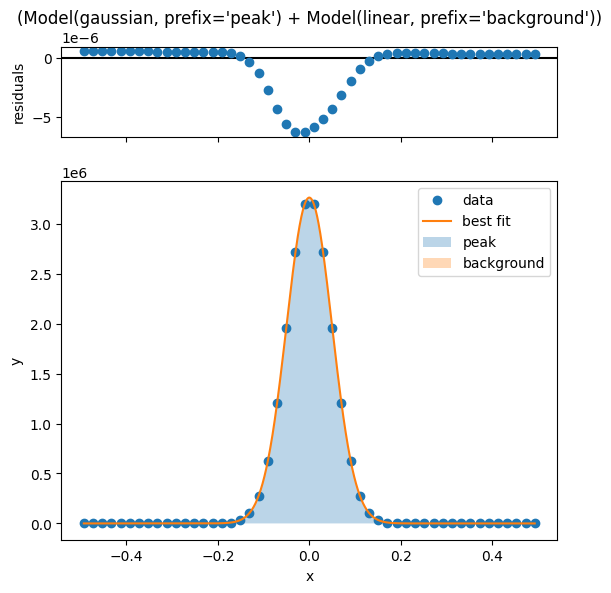

[[Model]]
    (Model(gaussian, prefix='peak') + Model(linear, prefix='background'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 50
    # variables        = 5
    chi-square         = 2.4461e-10
    reduced chi-square = 5.4358e-12
    Akaike info crit   = -1292.16869
    Bayesian info crit = -1282.60857
    R-squared          = 1.00000000
##  Warning: uncertainties could not be estimated:
    peakcenter:           at initial value
[[Variables]]
    peakamplitude:        407704.502 (init = 482528.7)
    peakcenter:          -1.7472e-14 (init = -7.401487e-17)
    peaksigma:            0.04987484 (init = 0.05033557)
    backgroundslope:      2.7009e-07 (init = 9.271793e-11)
    backgroundintercept: -4.9024e-07 (init = 404986.5)
    peakfwhm:             0.11744628 == '2.3548200*peaksigma'
    peakheight:           3261174.59 == '0.3989423*peakamplitude/max(1e-15, peaksigma)'


<Axes: xlabel='x', ylabel='y'>

In [18]:
lm.plot_fit(numpoints=1000)

## Access the fit values

The x and y values of the fit are stored in the `.x` (identical to the raw x values) and the `.y_fit` attributes.

In [19]:
lm.x

array([-0.493289, -0.473154, -0.45302 , ...,  0.45302 ,  0.473154,
        0.493289], shape=(50,))

In [20]:
lm.y_fit

array([-6.234715e-07, -6.180334e-07, -6.125915e-07, ..., -3.678821e-07,
       -3.624480e-07, -3.570101e-07], shape=(50,))

The residuals are stored within the `ModelResult` class of the lmfit package, which is stored in the `.modelresult` attribute of the `LinecutModel` class.

In [21]:
lm.modelresult.residual

array([6.234715e-07, 6.180335e-07, 6.125955e-07, ..., 3.678861e-07,
       3.624481e-07, 3.570101e-07], shape=(50,))

If `.plot_fit()` has already been called, then the evaluated data composing the fit curve can be found in `.x_eval` and `.y_eval`.

In [22]:
lm.x_eval

array([-0.493289, -0.492301, -0.491313, ...,  0.491313,  0.492301,
        0.493289], shape=(1000,))

In [23]:
lm.y_eval

array([-6.234715e-07, -6.232047e-07, -6.229380e-07, ..., -3.575436e-07,
       -3.572768e-07, -3.570101e-07], shape=(1000,))

If `.plot_fit()` has not been called, then evaluating the fit can be done in the standard `lmfit` way through the `ModelResult` object for either the total model or its individual components.

In [24]:
# Evaulate the total model
lm.modelresult.eval(x=np.linspace(-0.5,0.5,1000))

array([-6.252841e-07, -6.250138e-07, -6.247434e-07, ..., -3.557382e-07,
       -3.554678e-07, -3.551975e-07], shape=(1000,))

In [25]:
# Evaulate only the background component
lm.modelresult.components[1].eval(x=np.linspace(-0.5,0.5,1000))

array([-0.5     , -0.498999, -0.497998, ...,  0.497998,  0.498999,
        0.5     ], shape=(1000,))

You may also opt to evaluate all components at the same time, but separated by their individual contribution.

In [26]:
# Evaluate all components separately
evaluated_components = lm.modelresult.eval_components(x=np.linspace(-0.5,0.5,1000))

Using this approach, a `dict` is generated where the contribution of each component is labeled by its prefix.

In [27]:
evaluated_components

{'peak': array([4.892499e-16, 5.981719e-16, 7.310488e-16, ..., 7.310488e-16,
        5.981719e-16, 4.892499e-16], shape=(1000,)),
 'background': array([-6.252841e-07, -6.250138e-07, -6.247434e-07, ..., -3.557382e-07,
        -3.554678e-07, -3.551975e-07], shape=(1000,))}

In [28]:
evaluated_components['peak']

array([4.892499e-16, 5.981719e-16, 7.310488e-16, ..., 7.310488e-16,
       5.981719e-16, 4.892499e-16], shape=(1000,))

In [29]:
evaluated_components['background']

array([-6.252841e-07, -6.250138e-07, -6.247434e-07, ..., -3.557382e-07,
       -3.554678e-07, -3.551975e-07], shape=(1000,))

These can then be plotted together to show their individual contributions. See below for an example.

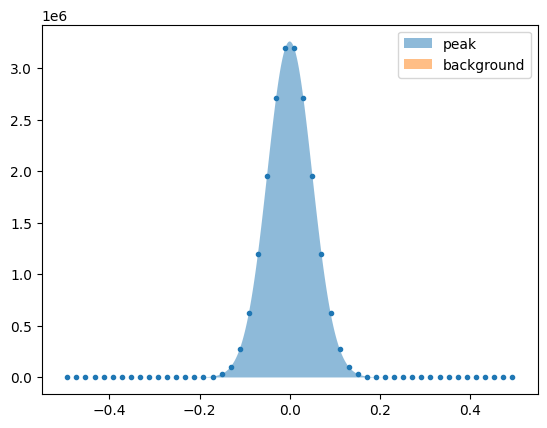

In [30]:
plt.plot(lm.x, lm.y, '.')
plt.fill_between(np.linspace(-0.5,0.5,1000), evaluated_components['peak'], alpha=0.5, label='peak')
plt.fill_between(np.linspace(-0.5,0.5,1000), evaluated_components['background'], alpha=0.5, label='background')
plt.legend()

## Viewing the fit report

In [31]:
lm.print_fit_report()

[[Model]]
    (Model(gaussian, prefix='peak') + Model(linear, prefix='background'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 50
    # variables        = 5
    chi-square         = 2.4461e-10
    reduced chi-square = 5.4358e-12
    Akaike info crit   = -1292.16869
    Bayesian info crit = -1282.60857
    R-squared          = 1.00000000
##  Warning: uncertainties could not be estimated:
    peakcenter:           at initial value
[[Variables]]
    peakamplitude:        407704.502 (init = 482528.7)
    peakcenter:          -1.7472e-14 (init = -7.401487e-17)
    peaksigma:            0.04987484 (init = 0.05033557)
    backgroundslope:      2.7009e-07 (init = 9.271793e-11)
    backgroundintercept: -4.9024e-07 (init = 404986.5)
    peakfwhm:             0.11744628 == '2.3548200*peaksigma'
    peakheight:           3261174.59 == '0.3989423*peakamplitude/max(1e-15, peaksigma)'


## Performing a simple linecut with no customization

The `.fit_peak_simple()` method offers a quick but rudimentary way to fit a peak, using a pseudo-Voigt peak shape with a linear background.

In [32]:
lm.fit_peak_simple()

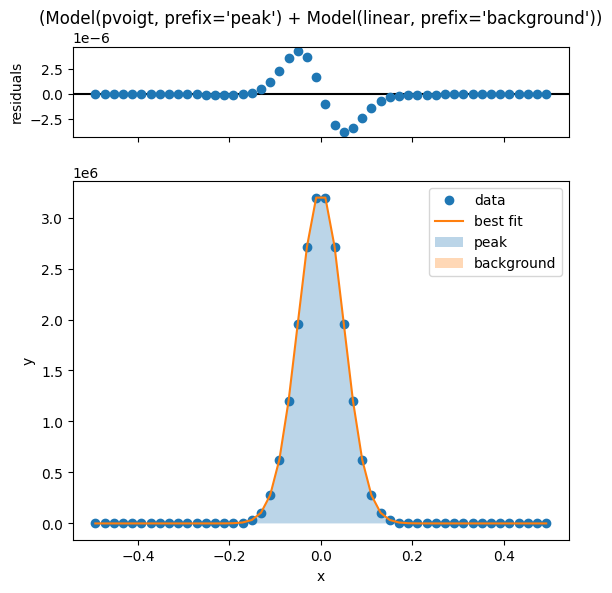

[[Model]]
    (Model(pvoigt, prefix='peak') + Model(linear, prefix='background'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 232
    # data points      = 50
    # variables        = 6
    chi-square         = 9.8388e-11
    reduced chi-square = 2.2361e-12
    Akaike info crit   = -1335.70602
    Bayesian info crit = -1324.23388
    R-squared          = 1.00000000
##  Warning: uncertainties could not be estimated:
    peakcenter:           at initial value
    peakfraction:         at boundary
    backgroundslope:      at initial value
[[Variables]]
    peakamplitude:        407704.502 (init = 603160.9)
    peakcenter:           1.0200e-13 (init = -7.401487e-17)
    peaksigma:            0.05872314 (init = 0.05033557)
    peakfraction:         3.4767e-13 (init = 0.5)
    peakfwhm:             0.11744628 == '2.0000000*peaksigma'
    peakheight:           3261174.43 == '(((1-peakfraction)*peakamplitude)/max(1e-15, (peaksigma*sqrt(pi/log(2))))+(peakfractio

<Axes: xlabel='x', ylabel='y'>

In [33]:
lm.plot_fit()